### Weather data

### Wunderground

In [1]:
import datetime
from dateutil.relativedelta import relativedelta
from urllib.request import urlretrieve
import os
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

##### Plotting

In [2]:
plt.figure(figsize = (8, 6))
sns.set_style("whitegrid", {'axes.linewidth': 1.5})
sns.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
# context = talk

***

In [3]:
start_date = datetime.datetime(2011,9,1)
end_date = datetime.datetime(2017,3,1)
places = ['NYC', 'LONDON', 'RJTD']
# RJTD = Tokyo, Japan

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

nm_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
leap_years = [2012, 2016]

#### Saving htmls to txt files

#### Scraping

In [4]:
for place in places:
    start_time = time.time()
    exec("pres_low_{} = pd.Series()".format(place))
    exec("pres_avg_{} = pd.Series()".format(place))
    exec("pres_high_{} = pd.Series()".format(place))
    
    for i in range(0, (diff_month(end_date, start_date)) + 1):
        year = (start_date + relativedelta(months = +i)).year
        month = (start_date + relativedelta(months = +i)).month

        page = open('weather/{}/wunderground_{}_{}_{}.txt'.format(place, place, year, month), 'r')
        soup = BeautifulSoup(page, 'html.parser')

        table = soup.find('table', attrs = {"class" : "responsive obs-table daily"})
        rows = table.findAll('tr')

        monthly_history =[]
        for tr in rows:
            cols = tr.findAll('td')
            text_data = []
            for td in cols:
                monthly_history.append(td.text.strip())

        if year in leap_years and month == 2:
            days = nm_days[month - 1] + 1
        else:
            days = nm_days[month - 1]

        df = pd.DataFrame()
        labels = monthly_history[0:21]

        for row in range(1, (days + 1)):
            for col in range(0, 21):
                df.loc[row, col] = monthly_history[21*row + col]

        df.columns = labels

        df['year'] = year
        df['month'] = month
        df['day'] = df.iloc[:,0]
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df.set_index('date')

        exec("pres_low_{} = pres_low_{}.append(pd.Series(df.iloc[:, 10]))".format(place, place))
        exec("pres_avg_{} = pres_avg_{}.append(pd.Series(df.iloc[:, 11]))".format(place, place))
        exec("pres_high_{} = pres_high_{}.append(pd.Series(df.iloc[:, 12]))".format(place, place))
        
    exec("print('{} is ready')".format(place))
    print("--- %s seconds ---" % (time.time() - start_time))

NYC is ready
--- 178.36036920547485 seconds ---
LONDON is ready
--- 171.66059637069702 seconds ---
RJTD is ready
--- 160.741229057312 seconds ---


In [5]:
for place in places:
    exec("df_pres{} = pd.concat([pres_high_{}, pres_avg_{}, pres_low_{}], axis = 1)".format(place, place, place, place))
    exec("df_pres{}.columns = ['low_{}', 'avg_{}', 'high_{}']".format(place, place, place, place))
    exec("df_pres{} = df_pres{}.replace('-', np.nan)".format(place, place))
    exec("print(df_pres{}.isnull().sum())".format(place))

low_NYC     19
avg_NYC     19
high_NYC    19
dtype: int64
low_LONDON     0
avg_LONDON     0
high_LONDON    0
dtype: int64
low_RJTD     461
avg_RJTD     461
high_RJTD    461
dtype: int64


In [6]:
df_presNYC = df_presNYC.astype(float).interpolate(method = 'linear')
df_presRJTD = df_presRJTD.replace(np.nan, 0)

In [7]:
df_presNYC.head()

,low_NYC,avg_NYC,high_NYC
2011-09-01,1020.0,1021.0,1022.0
2011-09-02,1018.0,1019.0,1021.0
2011-09-03,1012.0,1014.0,1017.0
2011-09-04,1010.0,1012.0,1014.0
2011-09-05,1008.0,1009.0,1011.0


In [8]:
for place in places:    
    exec("df_pres{}['in_day_diff_{}'] = df_pres{}.high_{}.astype(float) - df_pres{}.low_{}.astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{}['between_days_diff_{}'] = df_pres{}.avg_{}.astype(float) - df_pres{}.high_{}.shift(1).astype(float)"\
         .format(place, place, place, place, place, place))
    exec("df_pres{} = df_pres{}.replace(np.nan, 0)".format(place, place))
    exec("print(df_pres{}.isnull().sum())".format(place))

low_NYC                  0
avg_NYC                  0
high_NYC                 0
in_day_diff_NYC          0
between_days_diff_NYC    0
dtype: int64
low_LONDON                  0
avg_LONDON                  0
high_LONDON                 0
in_day_diff_LONDON          0
between_days_diff_LONDON    0
dtype: int64
low_RJTD                  0
avg_RJTD                  0
high_RJTD                 0
in_day_diff_RJTD          0
between_days_diff_RJTD    0
dtype: int64


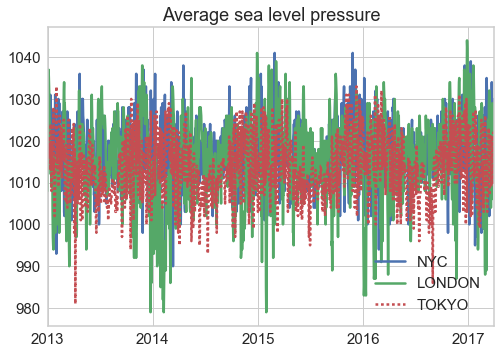

In [9]:
df_presNYC.ix['2013-01-01':].iloc[:,1].plot(style = '-')
df_presLONDON.astype(float).ix['2013-01-01':].iloc[:,1].plot(style = '-')
df_presRJTD.astype(float).ix['2013-01-01':].iloc[:,1].plot(style = ':')
plt.legend(['NYC', 'LONDON', 'TOKYO'], loc = 'lower right')
plt.title('Average sea level pressure')

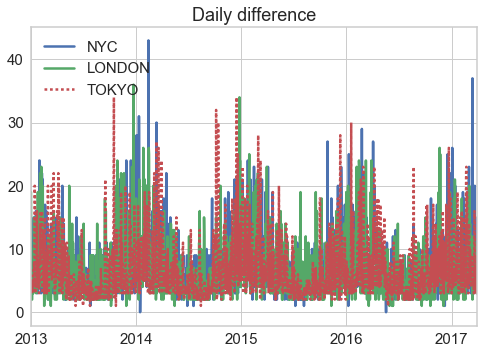

In [10]:
df_presNYC.ix['2013-01-01':].iloc[:,3].plot(style = '-')
df_presLONDON.astype(float).ix['2013-01-01':].iloc[:,3].plot(style = '-')
df_presRJTD.astype(float).ix['2013-01-01':].iloc[:,3].plot(style = ':')
plt.legend(['NYC', 'LONDON', 'TOKYO'], loc = 'upper left')
plt.title('Daily difference')

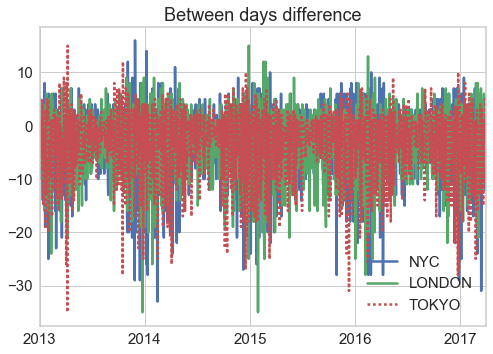

In [11]:
df_presNYC.ix['2013-01-01':].iloc[:,4].plot(style = '-')
df_presLONDON.astype(float).ix['2013-01-01':].iloc[:,4].plot(style = '-')
df_presRJTD.astype(float).ix['2013-01-01':].iloc[:,4].plot(style = ':')
plt.legend(['NYC', 'LONDON', 'TOKYO'], loc = 'lower right')
plt.title('Between days difference')